<a href="https://colab.research.google.com/github/Makrufkasr/Marketing_Campaign_Using_Statistics/blob/main/Marketing_Campaigns_Using_Statistics_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Marketing Campaign using A/B testing

**Background**:

"A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks."

Given this invofmation, by the end of this notebook we will be answering which promotion had a bigger impact in sales.

Let's begin by importing the necessary libraries and dataset:

In [ ]:
# Import Libary
import pandas as pd # Dataframe
import numpy as np # Process and manupulation number
import matplotlib.pyplot as plt # Data Visualization
import seaborn as sns # Data Visualization
import scipy.stats as stats # Statistics
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
#Import Dataset
marketing_campaign = pd.read_csv('https://docs.google.com/spreadsheets/d/1nCl_evlaMh7maLUMF2Q2sdnYtUfSAwbiu-6pRqHZMIM/export?format=csv&gid=1849995340')
marketing_campaign.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [ ]:
marketing_campaign.shape # to check len rows and columns

(548, 7)

In [ ]:
marketing_campaign.dtypes # Check type of data

MarketID              int64
MarketSize           object
LocationID            int64
AgeOfStore            int64
Promotion             int64
week                  int64
SalesInThousands    float64
dtype: object

In [ ]:
# Check null data each column
marketing_campaign.isna(). sum()

MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64

So Far, it looks like there are no null values in each column.

In [ ]:
marketing_campaign.duplicated(). sum()

0

Finally, after checking the data type, duplicated data and missing values. The data is ready to be processed for Exploratory Data Analysis.

In [ ]:
marketing_campaign.nunique()

MarketID             10
MarketSize            3
LocationID          137
AgeOfStore           25
Promotion             3
week                  4
SalesInThousands    517
dtype: int64

## Exploratory Data Analysis

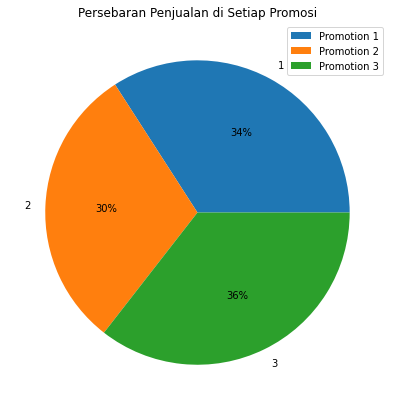

In [ ]:
ax = marketing_campaign.groupby(
    'Promotion'
).sum()[
    'SalesInThousands'
].plot.pie(
    figsize=(7, 7),
    autopct='%1.0f%%'
)
prom = ['Promotion 1', 'Promotion 2', 'Promotion 3']
ax.set_ylabel('')
ax.set_title('Persebaran Penjualan di Setiap Promosi')
plt.legend(prom, loc="upper right")

plt.show()

**Insight:**

Based on the pie chart above, it shows that the highest proportion of sales is in promotion 3 and promotion 1. Sales using promotion 2 are the lowest.

In [ ]:
# Total promotion in each promotion
count = pd.DataFrame(marketing_campaign.groupby(['Promotion'])['Promotion'].count())
count.rename(columns = {'Promotion': 'Count'}, inplace = True)
count.reset_index(inplace = True)
count

,Promotion,Count
0,1,172
1,2,188
2,3,188


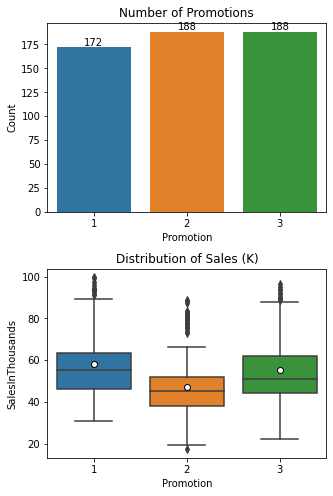

In [ ]:
fig, [ax, ax2] = plt.subplots(2, 1, figsize = (5, 8))

sns.barplot(y = 'Count', 
            x = 'Promotion', 
            data = count,
            ax = ax)

for container in ax.containers:
    ax.bar_label(container)
ax.set_title('Number of Promotions')

sns.boxplot(y = 'SalesInThousands',
            x = 'Promotion',
            data = marketing_campaign,
            showmeans = True,
            meanprops = {'markerfacecolor': 'white',
                         'markeredgecolor': 'black',
                         'marker' : 'o'},
            ax = ax2)
ax2.set_title('Distribution of Sales (K)')
fig.subplots_adjust(hspace = 0.3)

In the boxplots, it can be seen that the distribution of sales with promotions 1 and 3 is higher. Also, the white dot in each boxplot represents the average, which is also higher with promotions 1 and 3.

Let's do the same but use Market Size as well, to see if there is any difference between the two.

## Market Size

In [ ]:
marketing_campaign.groupby('MarketSize').count()['MarketID']

MarketSize
Large     168
Medium    320
Small      60
Name: MarketID, dtype: int64

The medium market still dominates with the highest number of market ids of 320 and the smallest is the small market with 60 market ids.

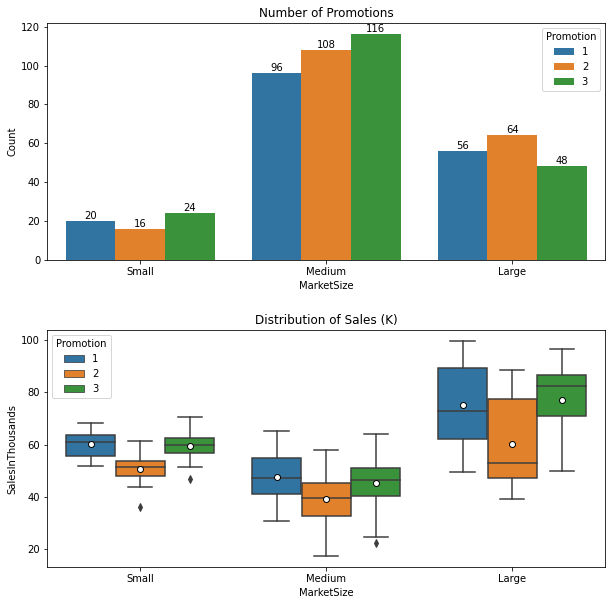

In [ ]:
count2 = pd.DataFrame(marketing_campaign.groupby(['MarketSize', 'Promotion'])['Promotion'].count())
count2.rename(columns = {'Promotion': 'Count'}, inplace = True)
count2.reset_index(inplace = True)

fig, [ax, ax2] = plt.subplots(2, 1, figsize = (10, 10))

sns.barplot(y = 'Count', 
            x = 'MarketSize',
            hue = 'Promotion',
            data = count2,
            order = ['Small', 'Medium', 'Large'],
            ax = ax)

for container in ax.containers:
    ax.bar_label(container)
ax.set_title('Number of Promotions')

sns.boxplot(y = 'SalesInThousands',
            x = 'MarketSize',
            hue = 'Promotion',
            data = marketing_campaign,
            order = ['Small', 'Medium', 'Large'],
            showmeans = True,
            meanprops = {'markerfacecolor': 'white',
                         'markeredgecolor': 'black',
                         'marker' : 'o'},
            ax = ax2)
ax2.set_title('Distribution of Sales (K)')
fig.subplots_adjust(hspace = 0.3)

Apparently the same thing is happening all over the market. This already gives us a hint of where we are going:

Promotions 1 and 3 seem to increase average sales, while promotion 2 doesn't seem to be as efficient.

Thus just looking at the Box Splot may not really answer for sure. To gain more ground in our conclusions, we can perform an ANOVA test, which will tell us if the average difference between promotions is statistically significant.

## Signifikan Test

Now it's time for the significant test. To investigate which campaign worked best, we used a t-test. What exactly does a t-test do? Simply put, it looks to see if the mean values of two groups are significantly different. Let's look at the average sales figures broken down by campaign.

In [ ]:
means = marketing_campaign.groupby('Promotion').mean()['SalesInThousands']
means

Promotion
1    58.099012
2    47.329415
3    55.364468
Name: SalesInThousands, dtype: float64

The mean value is different. But is this difference also significant? This question can be answered with a t-test. For this I used the t-test function from the scipy library.

There are two important statistics in the t-test, the t-value and the p-value.

The t-value measures the degree of difference relative to the variation in the data. The larger the t-value, the greater the difference between the two groups.

On the other hand, the p-value measures the probability that the result will appear by chance. The smaller the p-value, the more statistically significant the difference between the two groups.

In [ ]:
t, p = stats.ttest_ind(
    marketing_campaign.loc[marketing_campaign['Promotion'] == 1, 'SalesInThousands'].values, 
    marketing_campaign.loc[marketing_campaign['Promotion'] == 2, 'SalesInThousands'].values, 
    equal_var=False
)
print("t-Value: " + str('{:.3f}'.format(t)))
print("p-Value: " + str('{:.3f}'.format(p)))


t-Value: 6.428
p-Value: 0.000


Promotion 1 vs Promotion 3

In [ ]:
t, p = stats.ttest_ind(
    marketing_campaign.loc[marketing_campaign['Promotion'] == 1, 'SalesInThousands'].values, 
    marketing_campaign.loc[marketing_campaign['Promotion'] == 3, 'SalesInThousands'].values, 
    equal_var=False
)
print("t-Value: " + str('{:.3f}'.format(t)))
print("p-Value: " + str('{:.3f}'.format(p)))

t-Value: 1.556
p-Value: 0.121


Promotion 2 vs Promotion 3

In [ ]:
t, p = stats.ttest_ind(
    marketing_campaign.loc[marketing_campaign['Promotion'] == 2, 'SalesInThousands'].values, 
    marketing_campaign.loc[marketing_campaign['Promotion'] == 3, 'SalesInThousands'].values, 
    equal_var=False
)
print("t-Value: " + str('{:.3f}'.format(t)))
print("p-Value: " + str('{:.3f}'.format(p)))

t-Value: -4.881
p-Value: 0.000


Insight!

As we can see from the p-value, the average value of sales figures on promotions 1 and 3 is not significantly different. But the difference between promotion 1 and 2 is as good as promotion 2 vs 3. If you look at the corresponding t-value, you can say that promotion 1 and 3 are better than promotion 2.